# TWSQ Research Paper: Kelile Southwell
## Correlated Pairs Trading (Testing Set)

1. Get data on returns for TESTING SET

In [255]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 

client = bnb_client(tld='US')

def get_binance_px(symbol,freq,start_ts = '2024-07-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

#these are all of the coins I could find on binance whose data is accessible for USDT and USDC
univ = ['BTCUSDC', 'BTCUSDT', 
        'ETHUSDC', 'ETHUSDT', 
        'SOLUSDC', 'SOLUSDT', 
        'ADAUSDC', 'ADAUSDT',
        'XRPUSDT', 'XRPUSD', 
        'AVAXUSDT', 'AVAXUSD',
        'BNBUSDT', 'BNBUSD', 
        'DOGEUSDT', 'DOGEUSD',
        'SUIUSDT', 'SUIUSD',
        'BCHUSDT', 'BCHUSD',
        'LTCUSDT', 'LTCUSD',
        'SHIBUSDT', 'SHIBUSD',
        'DOTUSDT', 'DOTUSDT',
        'PEPEUSDT', 'PEPEUSD',
        'AAVEUSDT', 'AAVEUSD',
        'UNIUSDT', 'UNIUSD',
        'LINKUSDT', 'LINKUSD',
        'HBARUSDT', 'HBARUSD',
        'XLMUSDT', 'XLMUSD']

freq = '1h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_18242/4203273624.py:16: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_18242/4203273624.py:17: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))


In [293]:
ret_test = ret["2024-07-02":"2025-07-30"]

In [294]:
all_coins = client.get_all_tickers()
all_coins = pd.DataFrame(data=all_coins)
all_coins[all_coins['symbol'].str.startswith('LTC')]

,symbol,price
4,LTCUSD4,96.2100
10,LTCUSDT,107.69000000
16,LTCBTC,0.00090100
356,LTCUSD,107.45000000


2. Getting cumulative returns

In [295]:
#basic cumulative returns formula
cumret_test = ret_test.fillna(0).add(1).cumprod().subtract(1)

4. Perform linear regressions to find betas between pairs (will use later for signal generation)

In [296]:
import statsmodels.api as sm

all_pair_betas = pd.DataFrame(index=["betas"])
processed_pairs = set()
#generating betas for each pair with nested for loops
for crypto1 in cumret_test.columns:
    for crypto2 in cumret_test.columns:
        if crypto1 != crypto2 and crypto1[:4] == crypto2[:4]:
            # Normalize the pair so that the order doesn't matter (alphabetically sorted)
            pair = tuple(sorted([crypto1, crypto2]))
            
            # Skip the pair if it has already been processed
            if pair in processed_pairs:
                continue
            
            # Mark the pair as processed
            processed_pairs.add(pair)

            model = sm.OLS(cumret_test[crypto2], cumret_test[crypto1]).fit()
            beta_value = model.params[crypto1]

            pair_name = f"{crypto1}/{crypto2}"
            all_pair_betas[pair_name] = [beta_value] 

all_pair_betas

,BTCUSDC/BTCUSDT,ETHUSDC/ETHUSDT,SOLUSDC/SOLUSDT,ADAUSDC/ADAUSDT,XRPUSDT/XRPUSD,AVAXUSDT/AVAXUSD,BNBUSDT/BNBUSD,DOGEUSDT/DOGEUSD,SUIUSDT/SUIUSD,BCHUSDT/BCHUSD,LTCUSDT/LTCUSD,SHIBUSDT/SHIBUSD,PEPEUSDT/PEPEUSD,AAVEUSDT/AAVEUSD,UNIUSDT/UNIUSD,LINKUSDT/LINKUSD,HBARUSDT/HBARUSD,XLMUSDT/XLMUSD
betas,0.996145,1.007536,0.971824,0.999848,0.013223,0.241877,0.175743,-0.040283,-0.003792,0.644036,-0.186646,0.143935,0.09852,-0.019969,0.335842,0.038418,-0.014112,-0.019348


5. Signal Generation

Using residuals (calculated from betas), get rolling Bollinger Z-Scores of each pair to judge how big the deviation is statistically

In [297]:
all_residuals = pd.DataFrame(index=cumret_test.index, columns=all_pair_betas.columns)
all_signals = pd.DataFrame(index=cumret_test.index, columns=all_pair_betas.columns)

#generating betas for each pair with nested for loops
for crypto_pair in all_residuals:
     if 0.8 < all_pair_betas[crypto_pair].values[0] < 1.2:
          crypto1, crypto2 = crypto_pair.split('/')

          beta = all_pair_betas[crypto_pair].values[0]
          all_residuals[crypto_pair] = cumret_test[crypto2] - all_pair_betas[crypto_pair].values[0] * cumret_test[crypto1]

for crypto_pair in all_signals:
      if 0.8 < all_pair_betas[crypto_pair].values[0] < 1.2:
           all_signals[crypto_pair] = (all_residuals[crypto_pair] - all_residuals[crypto_pair].rolling(365, min_periods=1, closed='left').mean() ) / all_residuals[crypto_pair].rolling(365, min_periods=1, closed='left').std() * np.sqrt(365)

all_signals = all_signals.dropna(axis=1, how='all')
all_signals[all_signals > 300] = 300
all_signals

,BTCUSDC/BTCUSDT,ETHUSDC/ETHUSDT,SOLUSDC/SOLUSDT,ADAUSDC/ADAUSDT
2024-07-02 00:00:00,NaN,NaN,NaN,NaN
2024-07-02 01:00:00,NaN,NaN,NaN,NaN
2024-07-02 02:00:00,-57.795622,21.565685,300.000000,-8.105554
2024-07-02 03:00:00,-45.498318,85.345612,25.121795,-60.132627
2024-07-02 04:00:00,18.338879,-121.852771,20.166609,-5.076438
...,...,...,...,...
2025-07-30 19:00:00,-3.539231,-12.807257,3.195294,0.375155
2025-07-30 20:00:00,-9.786777,-15.839775,-0.937621,-18.510590
2025-07-30 21:00:00,-7.143088,-28.585130,-9.125572,-18.427753
2025-07-30 22:00:00,7.755682,-26.325730,-1.278742,-34.479568


6. Confirm that the distrubution of the signals appears normal

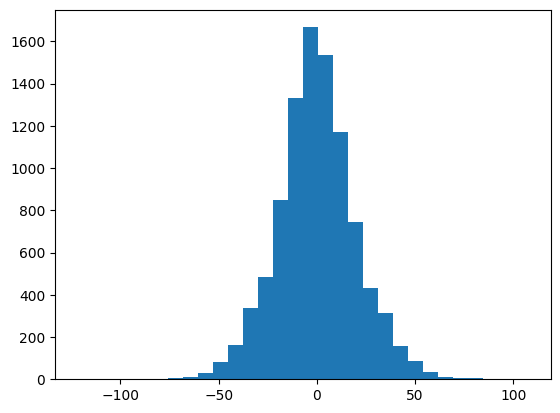

In [298]:
import matplotlib.pyplot as plt

#the distribution of the Bollinger Z-Scores (another safety check: if tails are too heavy, or distribution isn't centered, something is off)
plt.hist(all_signals['ETHUSDC/ETHUSDT'], bins=30)
plt.show()

7. Entrance

Signals above 1 std indicate that the deviation will revert within the day. The prediction coin is shorted, and the predicted coin is bought. The coin is held until the signal falls below 1. 

NOTE: raising the signal threshold will lower tcosts, but will lower sharpe.

In [358]:
all_weights = pd.DataFrame(index= cumret_test.index, columns=cumret_test.columns)

for crypto_pair in all_signals:
    crypto1, crypto2 = crypto_pair.split('/')
    signal_threshold = 30
    mask1 = all_signals[crypto_pair] > signal_threshold
    all_weights.loc[mask1, crypto1] = (1/ (all_signals[mask1] >  signal_threshold).sum(axis=1))

all_weights = all_weights.dropna(axis=1, how='all').fillna(0)
print(all_weights.tail())

                     BTCUSDC  ETHUSDC  SOLUSDC  ADAUSDC
2025-07-30 19:00:00      0.0      0.0      0.0      0.0
2025-07-30 20:00:00      0.0      0.0      0.0      0.0
2025-07-30 21:00:00      0.0      0.0      0.0      0.0
2025-07-30 22:00:00      0.0      0.0      0.0      0.0
2025-07-30 23:00:00      0.0      0.0      0.0      0.0


/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_18242/4201252973.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_weights = all_weights.dropna(axis=1, how='all').fillna(0)


8. Trading Frequency

A table to show how often trades are entered

In [359]:
#how frequently i'm making trades
freq = all_weights.astype(bool).sum() / len(all_weights.columns)
freq 

BTCUSDC    147.75
ETHUSDC    165.25
SOLUSDC    163.75
ADAUSDC    148.00
dtype: float64

9. Returns

<Axes: >

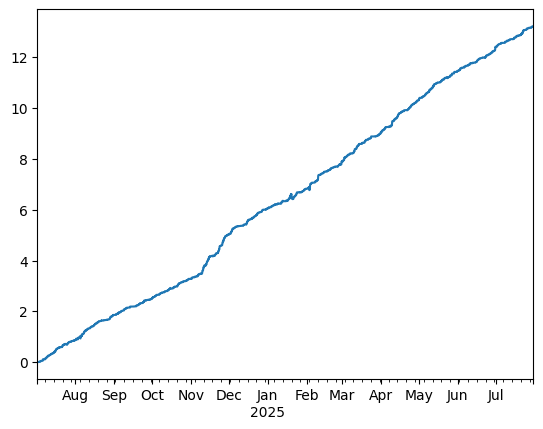

In [360]:
#fix: once we have our mulit-indexed dataframe of asset weights, we can get the sharpe of each strategy and output the mean, std, and sharpe into a table to display for the project
port_ret_test = (ret_test * all_weights.shift()).sum(1)

port_ret_test.cumsum().plot()

10. Beta and Alpha

Getting $SPY returns to calculate beta and alpha

In [362]:
import yfinance as yf

spy = yf.download("SPY", start="2023-07-02", end='2025-07-30')['Close']
spy_ret = spy.pct_change()

/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_18242/2713887481.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2023-07-02", end='2025-07-30')['Close']
[*********************100%***********************]  1 of 1 completed


11. Performing Linear Regression

In [363]:
X = spy_ret[['SPY']].fillna(0)
X = sm.add_constant(X)


Y = pd.DataFrame({"returns": port_ret_test}).dropna()
X, Y = X.align(Y, join='inner', axis=0)
results = sm.OLS(Y[["returns"]], X).fit()
print(results.params)
print(results.tvalues)

const    0.001521
SPY      0.100126
dtype: float64
const    4.186877
SPY      3.452239
dtype: float64


12. Getting Beta and Alpha Contributions

In [364]:
beta_contr = results.params['SPY']*X['SPY']
prediction = results.params['SPY']*X['SPY'] + results.params['const']
alpha_contr = results.params['const'] + results.resid

13. Calculating turnover and returns net of trading costs

In [365]:
tcost = 20

turnover = (all_weights - all_weights.shift()).abs().sum(1)
net_ret =  port_ret_test.subtract(turnover*tcost*1e-4, fill_value=0)

14. Calculating drawdown duration maximum and performance summary for testING SET

In [366]:
def ddd(port_ret):
    cumulative = port_ret_test.add(1).cumprod()
    peak = cumulative.cummax()
    underwater = cumulative < peak

    duration = pd.Series(0, index=port_ret_test.index)
    count = 0

    for i in range(len(port_ret_test)):
        if underwater.iloc[i]:
            count += 1
            duration.iloc[i] = count
        else:
            count = 0
            duration.iloc[i] = 0

    return duration


uncon_backtest_summary = {}
uncon_backtest_summary["mean"] = port_ret_test.mean() * 365
uncon_backtest_summary["std"] = port_ret_test.std() * np.sqrt(365)
uncon_backtest_summary["gross sharpe"] = port_ret_test.mean() / port_ret_test.std() * np.sqrt(365)
uncon_backtest_summary["net sharpe"] = net_ret.mean() / net_ret.std() * np.sqrt(365)
uncon_backtest_summary["max drawdown"] = ddd(port_ret_test).max()
uncon_backtest_summary["alpha"] = alpha_contr.mean()
uncon_backtest_summary["beta"] = beta_contr.mean()
uncon_backtest_summary = pd.Series(data=uncon_backtest_summary)
formatted_summary = uncon_backtest_summary.map(lambda x: f"{x:.6f}")
print(formatted_summary)


mean              0.510066
std               0.129876
gross sharpe      3.927321
net sharpe        2.226522
max drawdown    104.000000
alpha             0.001521
beta              0.000069
dtype: object
